## Image contours and masks with SAM (Segment Anything Model) Take #2

More experiments with Meta's https://github.com/facebookresearch/segment-anything

/home/jd/segment-anything/notebooks/images/dog.jpg ; exist: True
/home/jd/segment-anything/models/sam_vit_h_4b8939.pth ; exist: True
PyTorch version: 1.13.1
Torchvision version: 0.14.1
CUDA is available: True


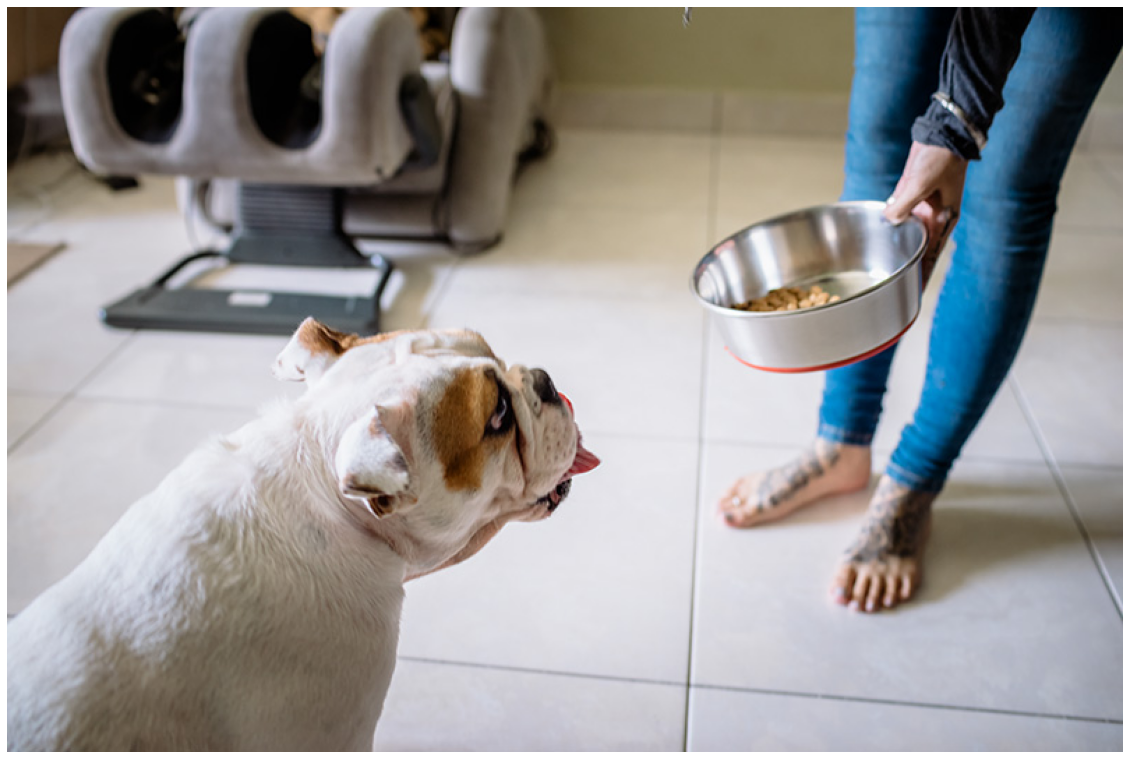

In [1]:
# Setup
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

IMAGE_PATH = "/home/jd/segment-anything/notebooks/images/dog.jpg"
print(IMAGE_PATH, "; exist:", os.path.isfile(IMAGE_PATH))
CHECKPOINT_PATH = "/home/jd/segment-anything/models/sam_vit_h_4b8939.pth"
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())

image_sam = cv2.imread(IMAGE_PATH)
image_sam = cv2.cvtColor(image_sam, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(20,20))
plt.imshow(image_sam)
plt.axis('off')
plt.show()
plt.close()
image_contour = image_sam.copy()

In [2]:
# Auto generate masks
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

CHECKPOINT_PATH = "/home/jd/segment-anything/models/sam_vit_h_4b8939.pth"
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))
MODEL_TYPE = "vit_h"
device = "cuda"

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH)
sam.to(device=device)
mask_generator = SamAutomaticMaskGenerator(sam)

/home/jd/segment-anything/models/sam_vit_h_4b8939.pth ; exist: True


In [3]:
# Details on masks
masks = mask_generator.generate(image_sam)
print(len(masks))
print(masks[0].keys())
print(masks[0]['segmentation'].shape)

66
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])
(534, 800)


In [4]:
# Get segmented areas and paint random colors in them
def show_masks(masks, num_masks=2, reverse=True):
    if len(masks) == 0:
        return masks
    sorted_masks = sorted(masks, key=(lambda x: x['area']), reverse=reverse)
    output_masks = np.ones((sorted_masks[0]['segmentation'].shape[0], sorted_masks[0]['segmentation'].shape[1], 4), dtype=float)
    output_masks[:,:,3] = 0 # clean up the last layer
    colors = [[1.0,1.0,0.0],[1.0,0.0,1.0],[0.0,1.0,1.0]]
    for index, mask in enumerate(sorted_masks):
        print(f"mask {index} area size {mask['area']}")
        seg = mask['segmentation']
        color_mask = np.concatenate([colors[index], [0.35]])
        output_masks[seg] = color_mask
        if index >= num_masks: break
    return output_masks[:,:,:3] #Only output first 3 layers

In [5]:
def merge_image(image_mask, pre_merge, alpha=0.5, beta=0.5, gamma=0.0):
    if np.issubdtype(image_mask.dtype, np.uint8):
        image_mask = image_mask / 255
    if np.issubdtype(pre_merge.dtype, np.uint8):
        pre_merge = pre_merge / 255
    print("image_mask", image_mask.shape, image_mask.dtype)
    print("pre_merge", pre_merge.shape, pre_merge.dtype)
    merged_image = cv2.addWeighted(image_mask, alpha, pre_merge, beta, gamma)
    return merged_image

mask 0 area size 186556
mask 1 area size 76377
mask 2 area size 76223
image_mask (534, 800, 3) float64
pre_merge (534, 800, 3) float64


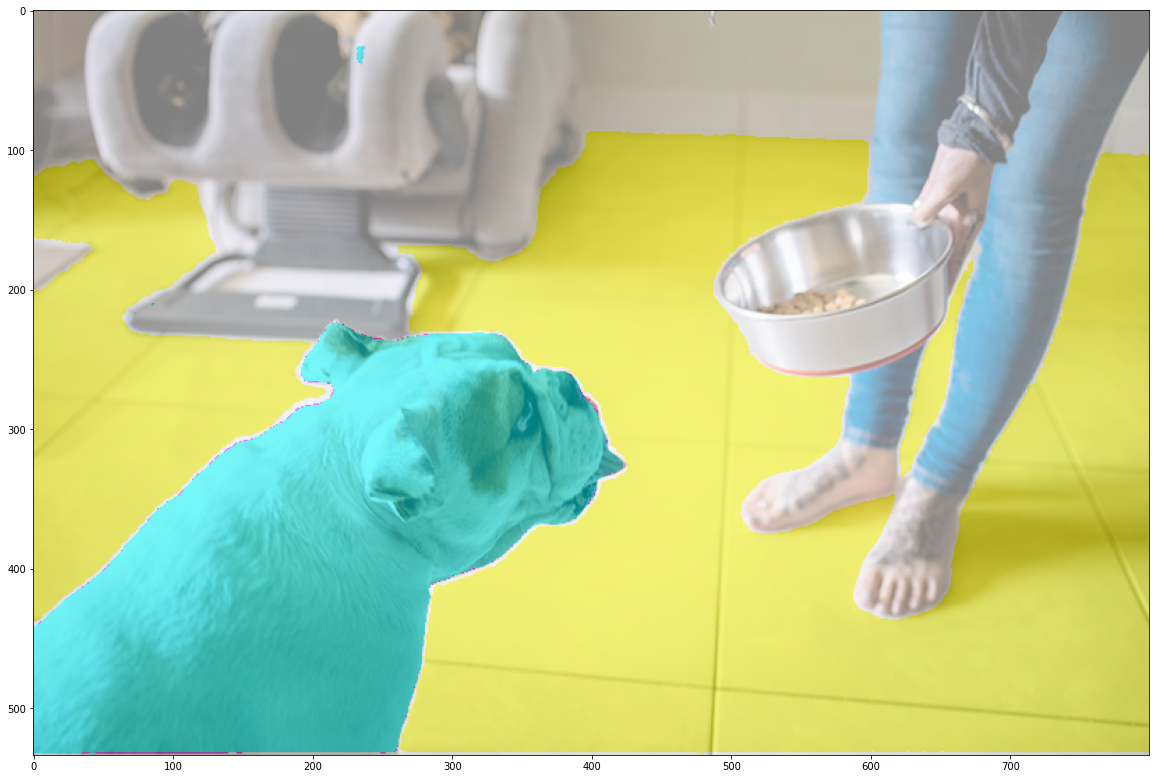

In [6]:
# Output SAM image
merged_image = merge_image(show_masks(masks), image_sam)
plt.figure(figsize=(20,20))
plt.imshow(merged_image)
plt.show()
plt.close()

In [7]:
# Get masks and draw contours around them
def show_contours(masks, input_sam, num_contours=2, reverse=True):
    if len(masks) == 0:
        return
    sorted_masks = sorted(masks, key=(lambda x: x['area']), reverse=reverse) # sort masks by largest area
    output_contours = input_sam.copy()
    colors = [(255,255,0),(255,0,255),(0,255,255)]
    for index, mask in enumerate(sorted_masks):
        print(f"mask {index} area size {mask['area']}")
        mask_seg = mask['segmentation'] # Get segmentation mask
        mask_8bit = np.uint8(mask_seg * 255) # Convertion for contours
        contours = cv2.findContours(mask_8bit,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)[-2]
        cv2.drawContours(output_contours,contours,-1,colors[index],3)
        if index >= num_contours: break
    return output_contours

mask 0 area size 186556
mask 1 area size 76377
mask 2 area size 76223
image_mask (534, 800, 3) float64
pre_merge (534, 800, 3) float64


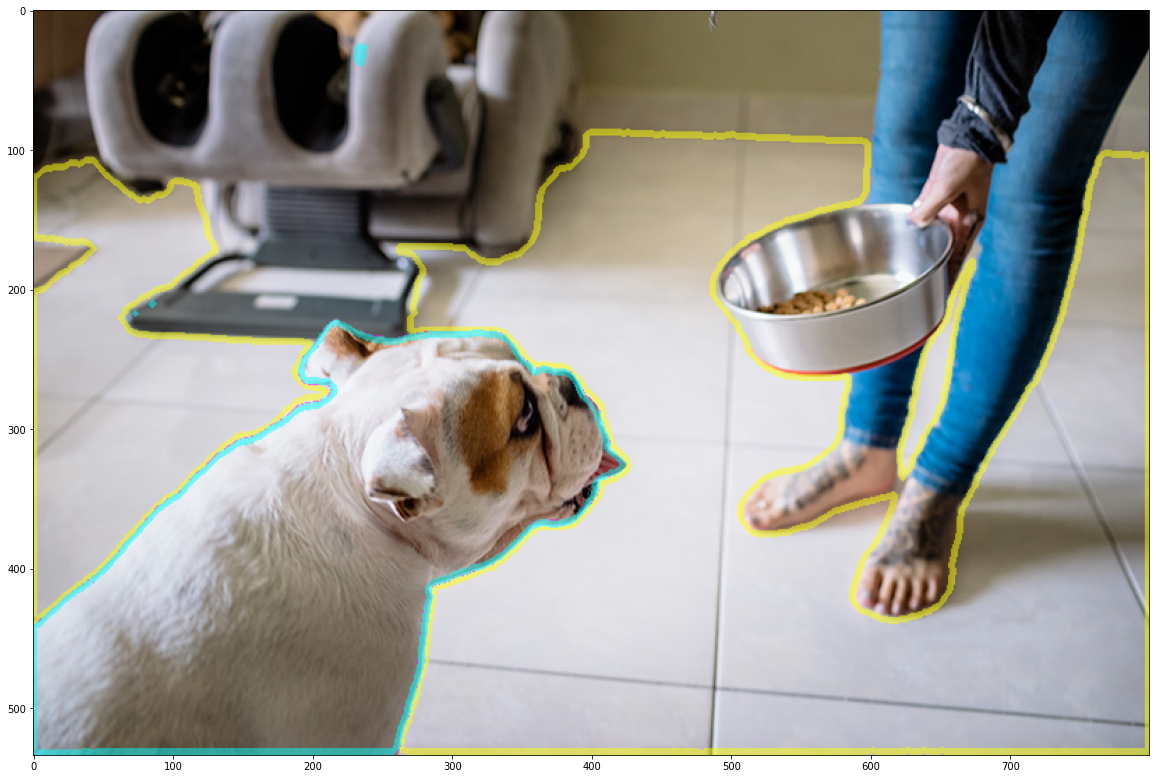

In [8]:
# Output contours
output_contours = show_contours(masks, image_contour)
merged_image_2 = merge_image(output_contours, image_contour)
plt.figure(figsize=(20,20))
plt.imshow(merged_image_2)
plt.show()
plt.close()

image_mask (534, 800, 3) float64
pre_merge (534, 800, 3) float64


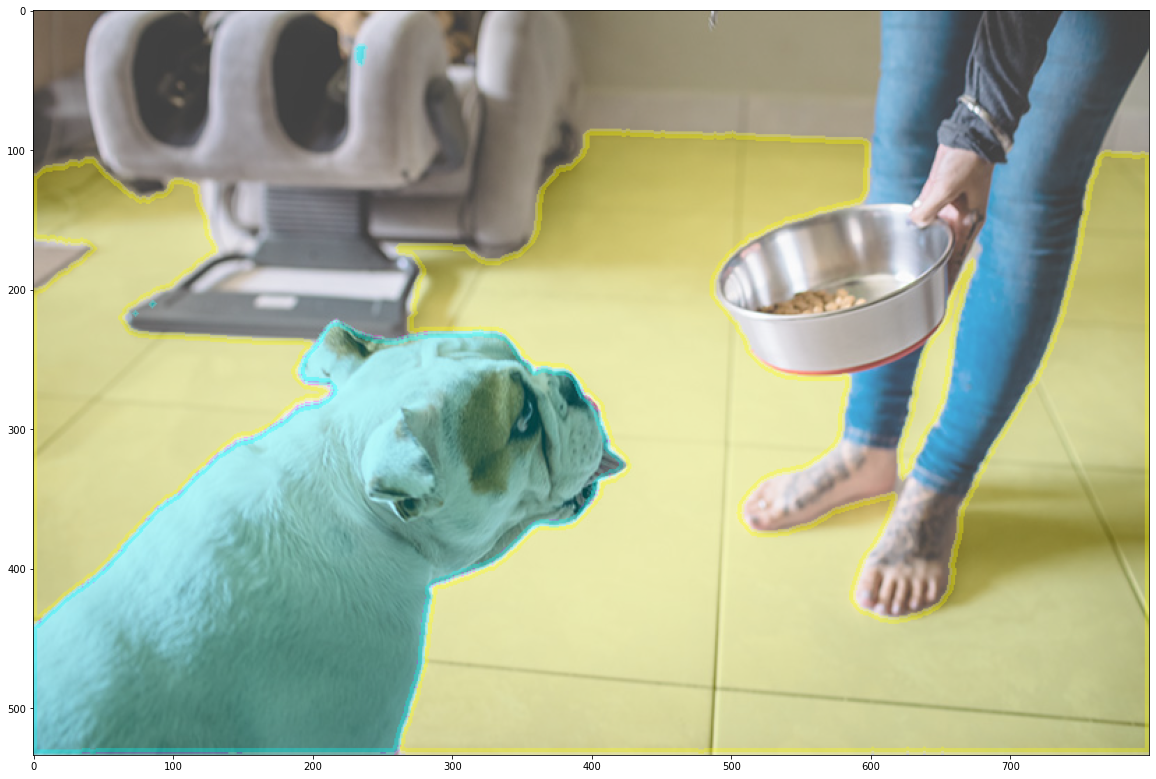

In [9]:
#Final merge
final_image = merge_image(merged_image, merged_image_2)
plt.figure(figsize=(20,20))
plt.imshow(final_image)
plt.show()
plt.close()